In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm 
import seaborn as sns
from patsy import dmatrix

In [8]:
# Load the combined data
combined_data = pd.read_csv("combined data.csv")

# Convert the 'Date' column to datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')
combined_data['Total_nonfarm'] = pd.to_numeric(combined_data['Total_nonfarm'], errors='coerce')
combined_data['Total_private'] = pd.to_numeric(combined_data['Total_private'], errors='coerce')

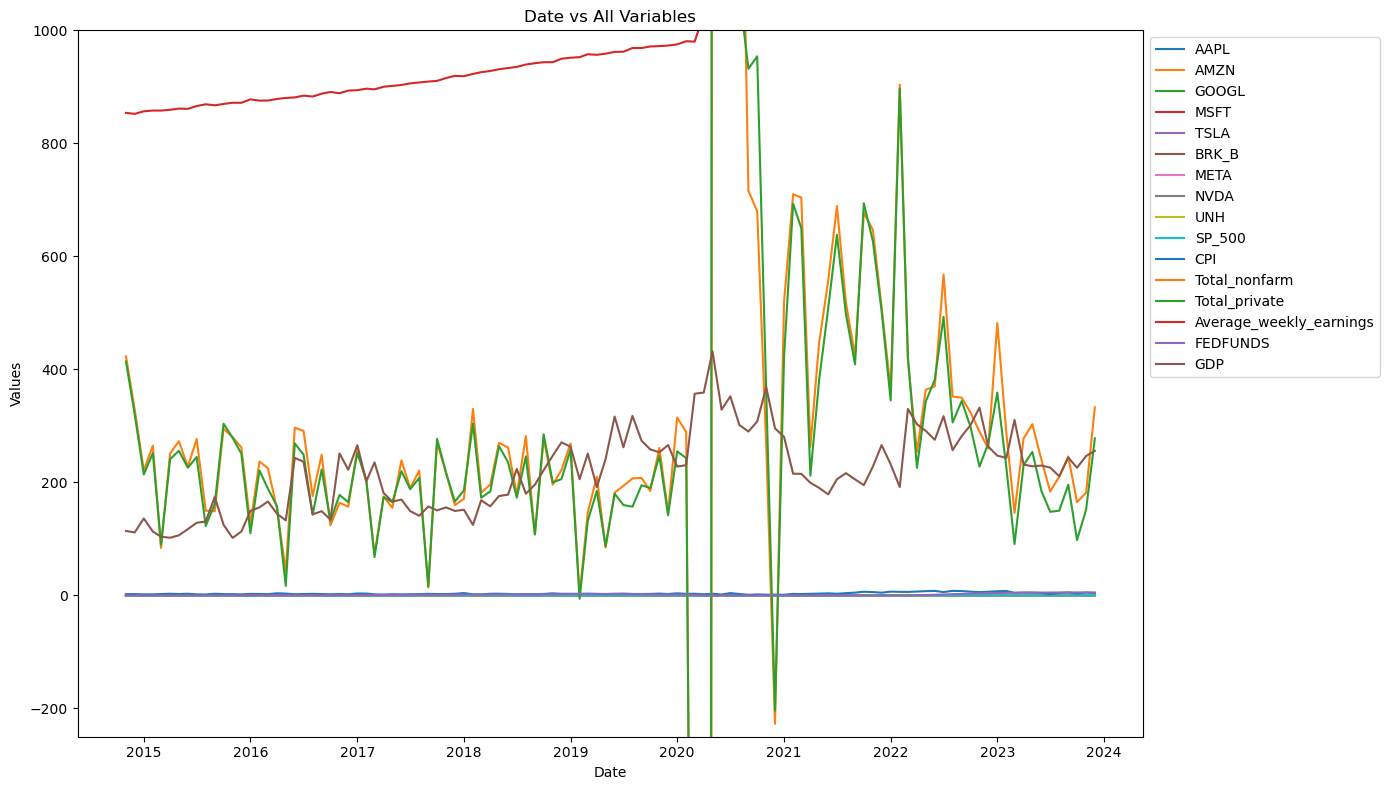

In [9]:
# List of variables to plot against Date
variables = [col for col in combined_data.columns if col != 'Date']

# Plot Date vs each variable
plt.figure(figsize=(14, 8))
for variable in variables:
    plt.plot(combined_data['Date'], combined_data[variable], label=variable)

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Date vs All Variables')
plt.ylim(-250, 1000)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

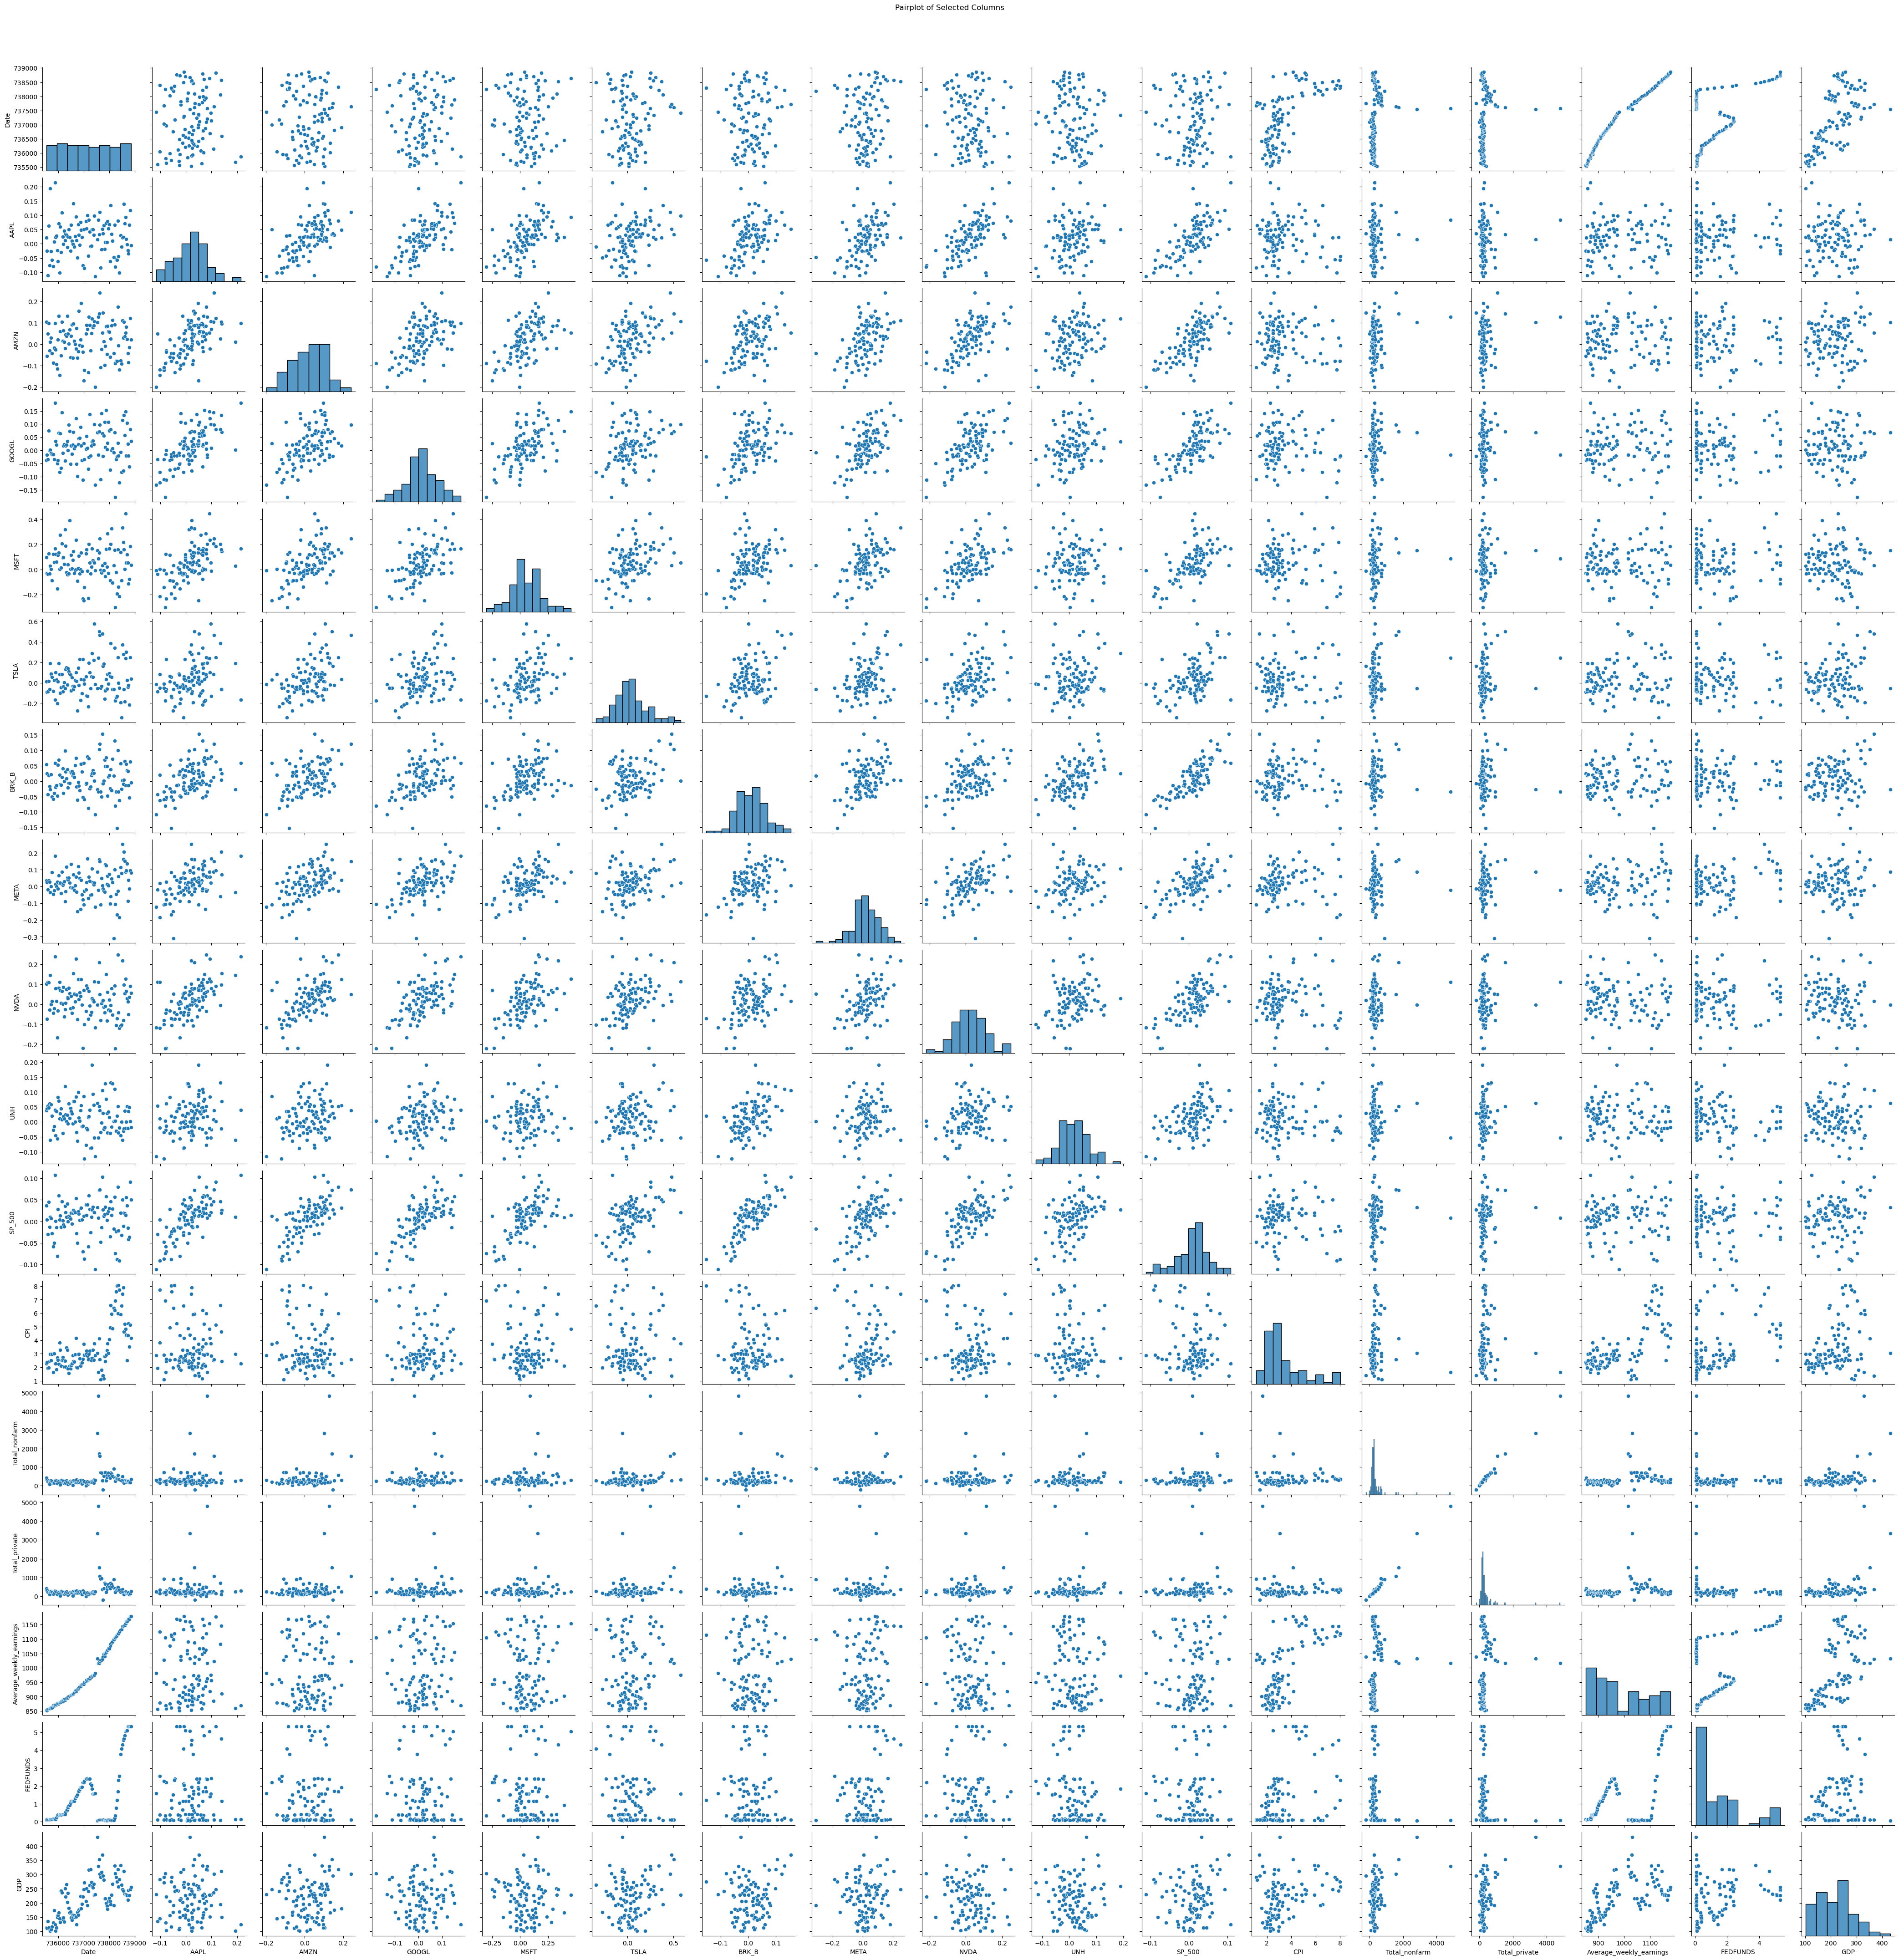

In [30]:
# Create a pairplot
sns.pairplot(combined_data)
plt.suptitle('Pairplot of Selected Columns', y=1.02)
plt.show()

In [10]:
combined_data['Date'] = combined_data['Date'].map(pd.Timestamp.toordinal)

independent_vars = [col for col in combined_data.columns if col != 'SP_500']
formula = 'SP_500 ~ ' + ' + '.join(independent_vars)

model = ols(formula, data=combined_data).fit()

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     39.47
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           2.24e-34
Time:                        18:14:36   Log-Likelihood:                 299.36
No. Observations:                 110   AIC:                            -564.7
Df Residuals:                      93   BIC:                            -518.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Multiple of the above variables have a very high p-value. I will remove variables one by one until I get all significant variables.

In [11]:
while True:
    p_values = model.pvalues.drop('Intercept')
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        worst_feature = p_values.idxmax()
        independent_vars.remove(worst_feature)
        formula = 'SP_500 ~ ' + ' + '.join(independent_vars)
        model = ols(formula, data=combined_data).fit()
    else:
        break
    
formula += '+ Date'

model = ols(formula, data=combined_data).fit()

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     75.95
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           2.87e-39
Time:                        18:14:39   Log-Likelihood:                 293.59
No. Observations:                 110   AIC:                            -569.2
Df Residuals:                     101   BIC:                            -544.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.7454      1.312     -0.568

Removing all p-values above 0.05 itereatively results in the above regression with only AAPL, AMZN, GOOGL, BRK_B, and UNH. This means that all of the other variables were not significant and should not be in the regression.

The Multiple Linear Regression result from these changes results in the formula:

$$\hat{y} = -0.0026 + 0.0815 \cdot AAPL + 0.1149 \cdot AMZN + 0.0974 \cdot GOOGL + 0.4284 \cdot BRK_B + 0.0732 \cdot NVDA - 4.84 \times 10^{-5} \cdot Total_nonfarm + 4.87 \times 10^{-5} \cdot Total_private$$

For every 1 unit increase in AAPL stock return, the S&P 500 stock return value is expected to increase by 0.0815.

For every 1 unit increase in AMZN stock return, the S&P 500 stock return value is expected to increase by 0.0.1149.

For every 1 unit increase in GOOGL stock return, the S&P 500 stock return value is expected to increase by 0.0974.

For every 1 unit increase in BRK B stock return, the S&P 500 stock return value is expected to increase by 0.0732.

For every 1 unit increase in NVDA stock return, the S&P 500 stock return value is expected to increase by 0.0732.

For every 1 unit increase in Total nonfarm employment, S&P 500 stock return value is expected to decrease by $4.84 \times 10^{-5}$.

For every 1 unit increase in Total private employment, S&P 500 stock return value is expected to increse by $4.87 \times 10^{-5}$.

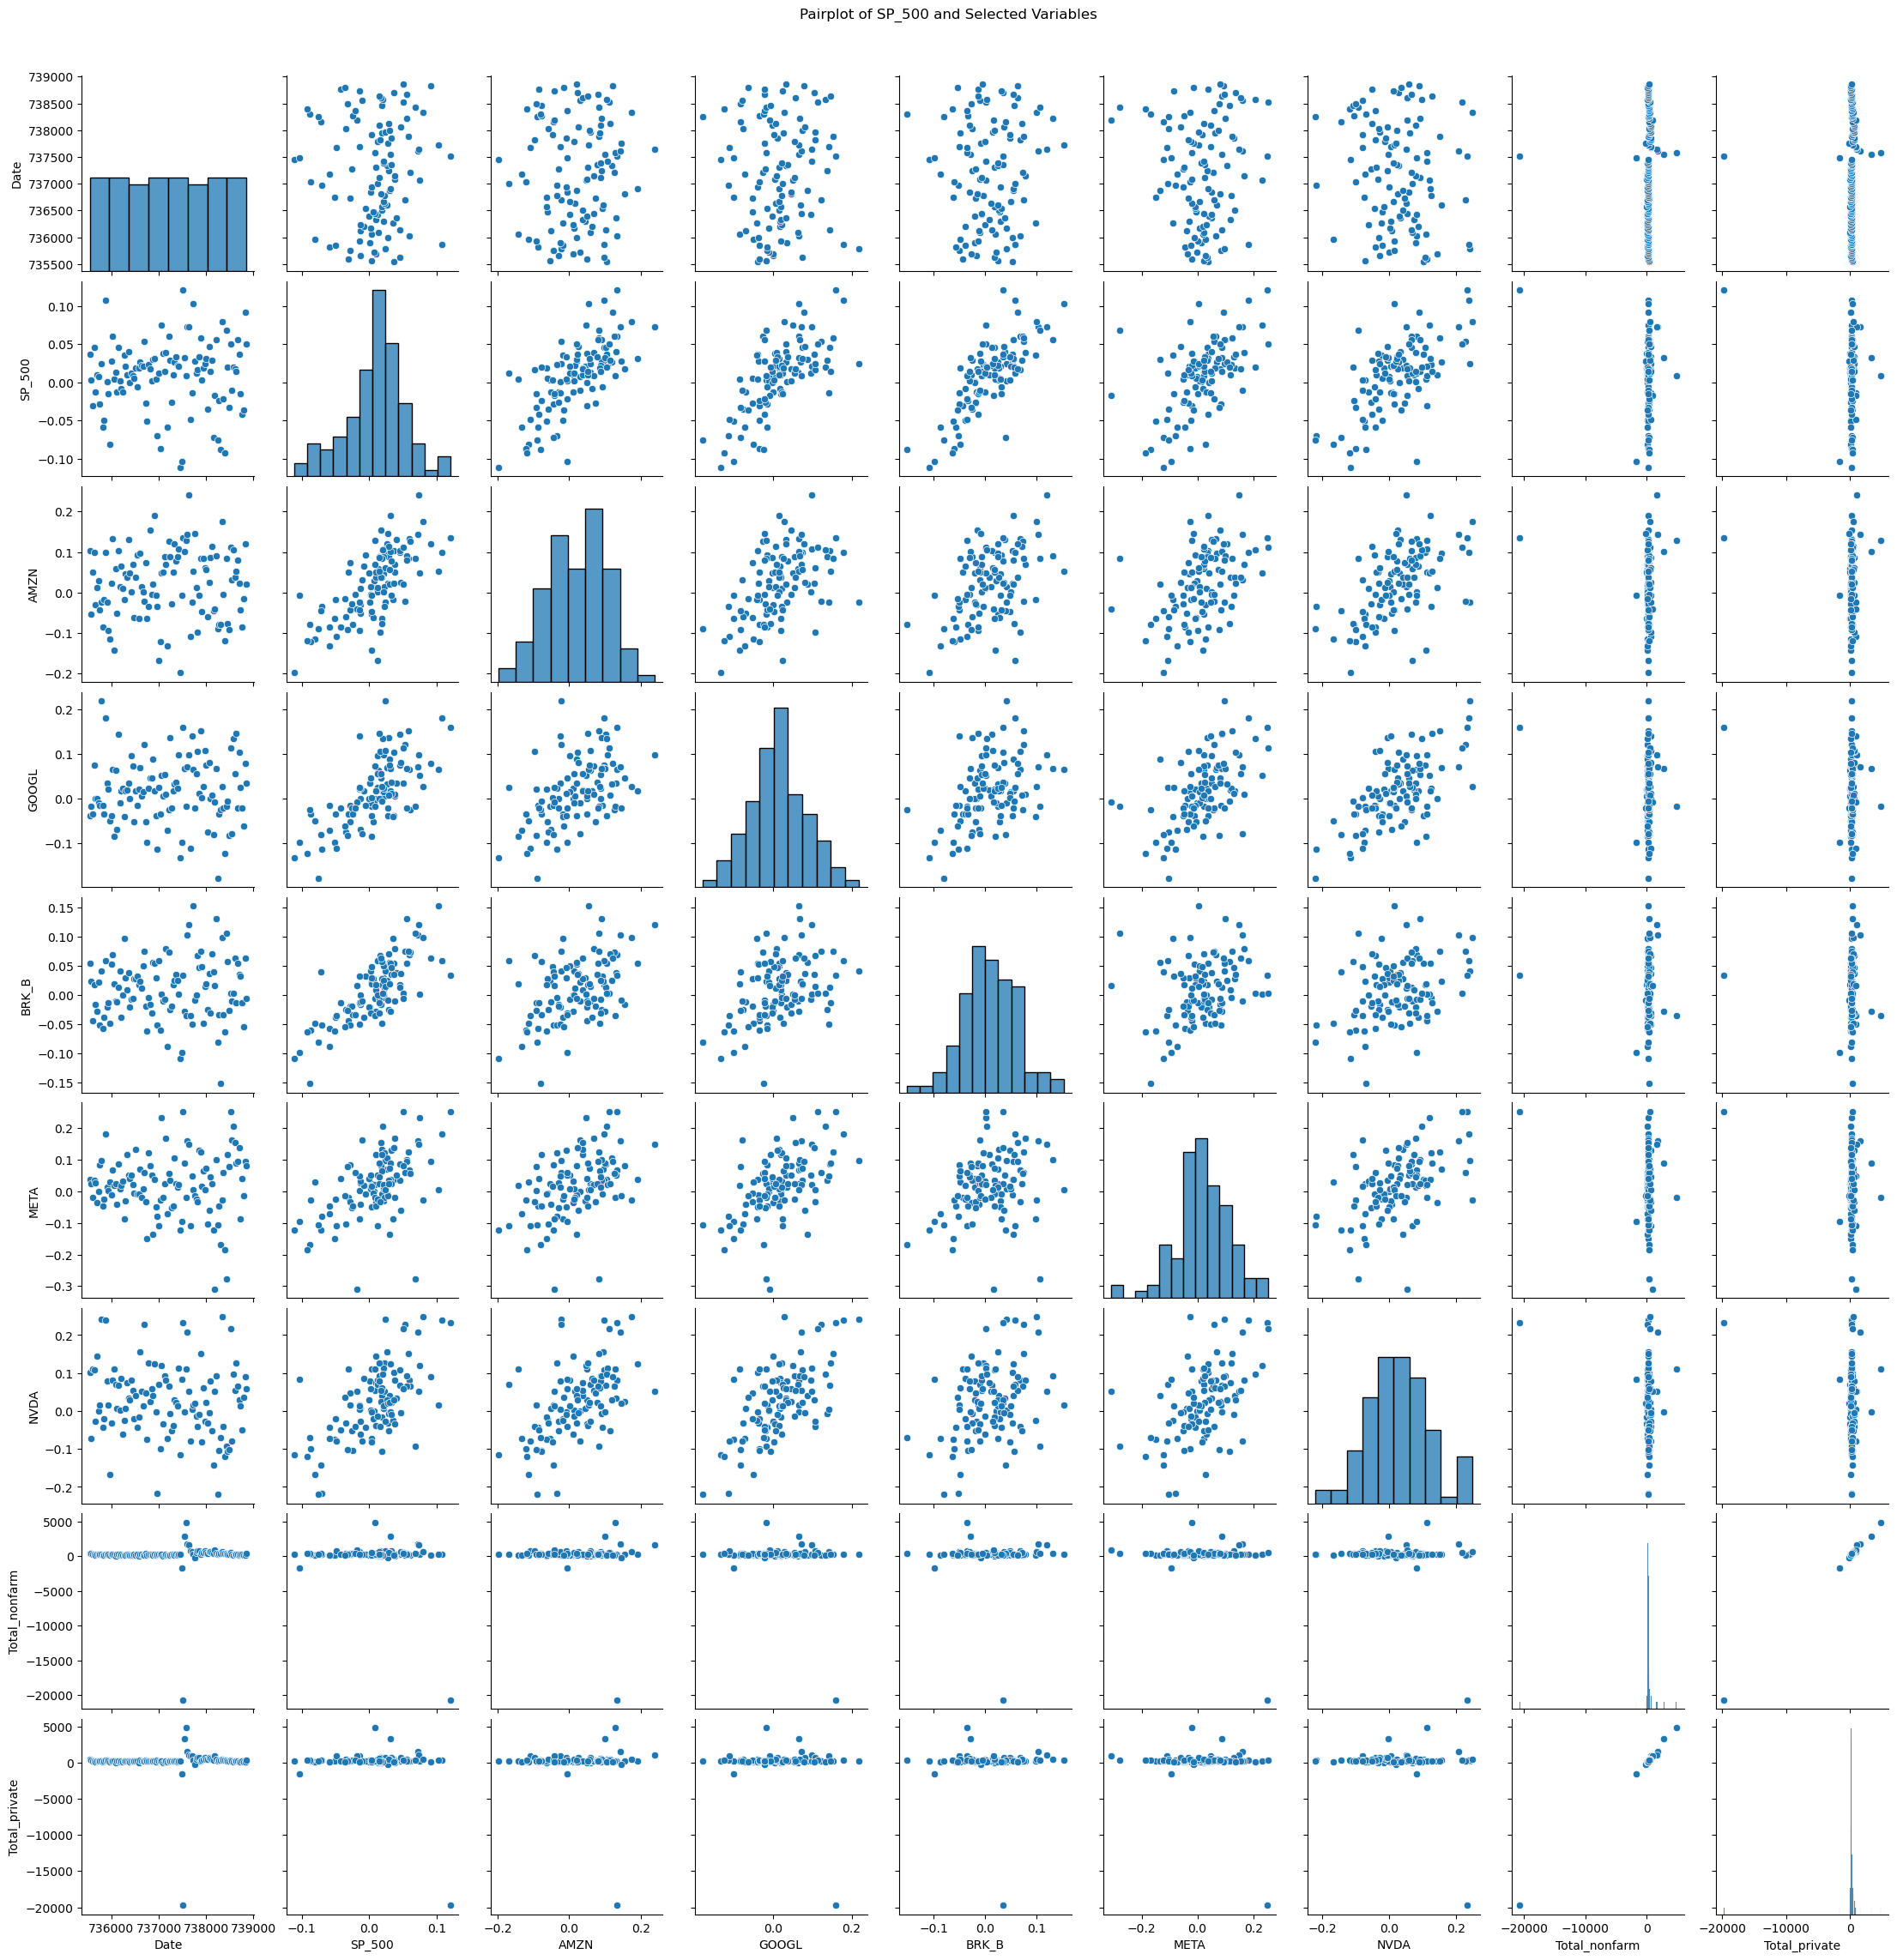

In [12]:
selected_vars = ['Date', 'SP_500'] + independent_vars
sns.pairplot(combined_data[selected_vars])
plt.suptitle('Pairplot of SP_500 and Selected Variables', y=1.02)
plt.show()

Index([8, 50, 64, 65, 86, 95], dtype='int64')


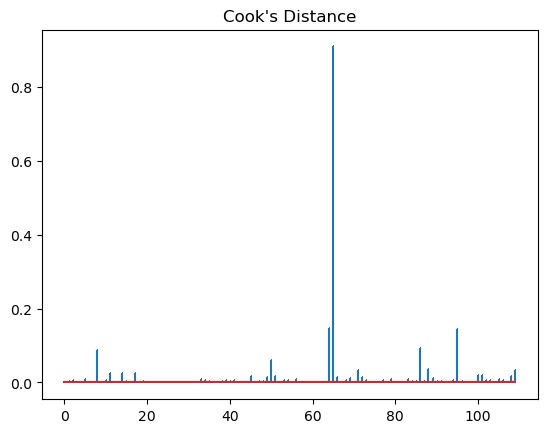

In [13]:
# Cook's Distance
influence = model.get_influence()
(c, p) = influence.cooks_distance
n = len(combined_data)
threshold = 4 / n
outliers = combined_data[c > threshold].index
print(outliers)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Cook's Distance")
plt.show()

As seen above in the Cook's Distance graph, the value at 2020-02-01 is considerably larger than the other values, so it is an influential point. This can be explained by the drastic drop in stock market at the beginning of the COVID-19 pandemic. I will remove this point and re-generate the model

In [14]:
# Remove the outliers
combined_data = combined_data.drop(outliers)

# Refit the model after removing outliers
independent_vars = [col for col in combined_data.columns if col != 'SP_500']
formula = 'SP_500 ~ ' + ' + '.join(independent_vars)
model = ols(formula, data=combined_data).fit()

# Iteratively remove variables with p-value > 0.05
while True:
    p_values = model.pvalues.drop('Intercept')
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        worst_feature = p_values.idxmax()
        independent_vars.remove(worst_feature)
        formula = 'SP_500 ~ ' + ' + '.join(independent_vars)
        model = ols(formula, data=combined_data).fit()
    else:
        break
    
formula += '+ Date'

model = ols(formula, data=combined_data).fit()

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     91.29
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           3.57e-41
Time:                        18:16:45   Log-Likelihood:                 296.32
No. Observations:                 104   AIC:                            -574.6
Df Residuals:                      95   BIC:                            -550.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.9784      1.150     -0.851

With this outlier removed, the variables that should be kept in the model have changed

The new formula for the regression is: 

$$\hat{y} = -0.9784 + 0.0802 \text{AAPL} + 0.1151 \text{AMZN} + 0.0943 \text{GOOGL} + 0.4277 \text{BRK B} + 0.0775 \text{NVDA} + -4.616 \times 10^{-5} \text{Total nonfarm} + 4.542 \times 10^{-5} \text{Total private} + 1.325 \times 10^{-6} \text{Date}$$

In [15]:
# calculate the sum of (y_i - y_hat_i)^2
y_hat = model.predict()
y = combined_data['SP_500']
residuals = y - y_hat
SSE = (residuals**2).sum()
print(SSE)

0.020405145042962515


The PRESS (Predicted Error Sum of Squares) statistic of 0.020 is low, meaning that the model will perform well. This also matches the F-statistic p-value of $3.57 \times 10^{-41}$ which is extremely small.

The $R^2_{Adj}$ value is 0.885 which means that the model explains 88.5% of the variability. This indicates a strong relationship between the predictors and the S&P 500 value.

This would be a good result if we were able to use stock markets to predict the S&P 500, but since these stock markets are in the calculation of what the value of the S&P 500 are, it has data leakage. Let's run a regression on Total_nonfarm and Total_private and see the result.

In [16]:
independent_vars = [col for col in combined_data.columns if col != 'SP_500']
formula = 'SP_500 ~ Total_nonfarm + Total_private'

model = ols(formula, data=combined_data).fit()

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.629
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.201
Time:                        18:17:03   Log-Likelihood:                 185.56
No. Observations:                 104   AIC:                            -365.1
Df Residuals:                     101   BIC:                            -357.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0041      0.005      0.829

As you can see, there are no significant variables that can predict the stock market using a Multiple Linear Regression